In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

In [2]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def fractal_dimension(Z, threshold=50):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [3]:
# Z = (rgb2gray(imageio.imread('3.png')) < 50)

# byteImgIO = io.BytesIO()
# byteImg = Image.fromarray(Z)
# byteImg = byteImg.convert("L")
# byteImg.save(byteImgIO, "PNG")
# byteImgIO.seek(0)
# byteImg = byteImgIO.read()
# dataBytesIO = io.BytesIO(byteImg)
# Image.open(dataBytesIO)

In [4]:
A1 = [rgb2gray(imageio.imread('A1-1.PNG')), 
      rgb2gray(imageio.imread('A1-2.PNG')),
      rgb2gray(imageio.imread('A1-3.PNG')),
      rgb2gray(imageio.imread('A1-4.PNG'))]

A2 = [rgb2gray(imageio.imread('A2-1.png')), 
      rgb2gray(imageio.imread('A2-2.PNG')),
      rgb2gray(imageio.imread('A2-3.PNG'))]

B1 = [rgb2gray(imageio.imread('B1-1.PNG')), 
      rgb2gray(imageio.imread('B1-2.PNG')),
      rgb2gray(imageio.imread('B1-3.PNG'))]

B2 = [rgb2gray(imageio.imread('B2-0.PNG')), 
      rgb2gray(imageio.imread('B2-1.PNG')),
      rgb2gray(imageio.imread('B2-2.PNG')),
      rgb2gray(imageio.imread('B2-3.PNG')),
#       rgb2gray(imageio.imread('B2-4.PNG'))
     ]

C1 = [rgb2gray(imageio.imread('C1-1.PNG')), 
      rgb2gray(imageio.imread('C1-2.PNG')),
      rgb2gray(imageio.imread('C1-3.PNG')),
      rgb2gray(imageio.imread('C1-4.PNG'))]

D1 = [rgb2gray(imageio.imread('D1-1.PNG')), 
      rgb2gray(imageio.imread('D1-2.PNG')),
      rgb2gray(imageio.imread('D1-3.PNG')),
      rgb2gray(imageio.imread('D1-4.PNG'))]

In [5]:
x_names = ["A1", "A2", "B1", "B2", "C1", "D1"]

Количество черных пикселей

In [6]:
def black(Cat):
    cat = []
    for c in Cat:
        cat.append(cv2.countNonZero(c))
    return cat

In [7]:
a1_black = black(A1)
a2_black = black(A2)
b1_black = black(B1)
b2_black = black(B2)
c1_black = black(C1)
d1_black = black(D1)

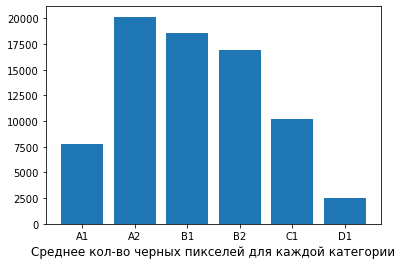

In [8]:
y_black = [np.mean(a1_black),np.mean(a2_black), np.mean(b1_black), np.mean(b2_black), np.mean(c1_black), np.mean(d1_black)]

plt.bar(x_names, y_black)
 
# Custom Axis title
plt.xlabel('Среднее кол-во черных пикселей для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

Количество белых пикселей

In [9]:
def white(Cat):
    cat = []
    for c in Cat:
        x,y = c.shape
        TotalNumberOfPixels = x * y
        cat.append(TotalNumberOfPixels - cv2.countNonZero(c))
    return cat

In [10]:
a1_white = white(A1)
a2_white = white(A2)
b1_white = white(B1)
b2_white = white(B2)
c1_white = white(C1)
d1_white = white(D1)

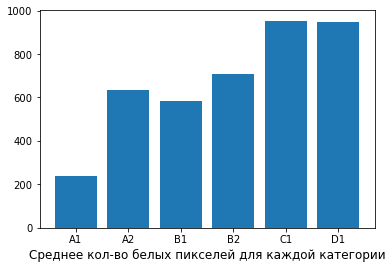

In [11]:
y_white = [np.mean(a1_white),np.mean(a2_white), np.mean(b1_white), np.mean(b2_white), np.mean(c1_white), np.mean(d1_white)]

plt.bar(x_names, y_white)
 
# Custom Axis title
plt.xlabel('Среднее кол-во белых пикселей для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

Отношение черных к белым

In [12]:
def relate(black, white):
    return [b / white[n] for n, b in enumerate(black)]

In [13]:
a1_relate = relate(a1_black, a1_white)
a2_relate = relate(a2_black, a2_white)
b1_relate = relate(b1_black, b1_white)
b2_relate = relate(b2_black, b2_white)
c1_relate = relate(c1_black, c1_white)
d1_relate = relate(d1_black, d1_white)

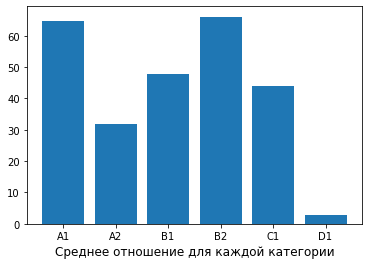

In [14]:
y_relate = [np.mean(a1_relate),np.mean(a2_relate), np.mean(b1_relate), np.mean(b2_relate), np.mean(c1_relate), np.mean(d1_relate)]

plt.bar(x_names, y_relate)
 
# Custom Axis title
plt.xlabel('Среднее отношение для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

In [15]:
data = pd.DataFrame([], columns=["Отношение", "Тип"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        x, y = c.shape
        TotalNumberOfPixels = x * y
        white = TotalNumberOfPixels - cv2.countNonZero(c)
        data = data.append({"Отношение": cv2.countNonZero(c)/white,"Тип": key}, ignore_index=True)

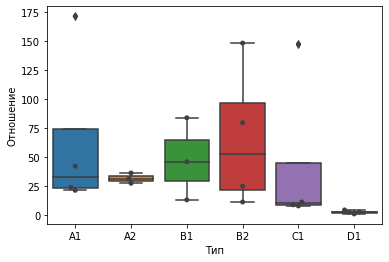

In [16]:
ax = sns.boxplot(x="Тип", y="Отношение", data=data)
ax = sns.swarmplot(x="Тип", y="Отношение", data=data, color=".25")

Фрактальный размер

In [17]:
def fract(Cat):
    cat = []
    for c in Cat:
        cat.append(fractal_dimension(c))
    return cat

In [18]:
a1_fract = fract(A1)
a2_fract = fract(A2)
b1_fract = fract(B1)
b2_fract = fract(B2)
c1_fract = fract(C1)
d1_fract = fract(D1)

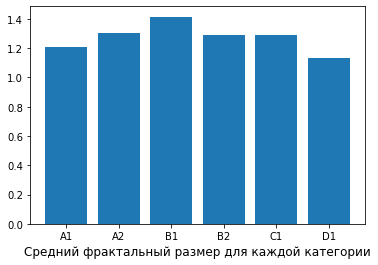

In [19]:
y_frac = [np.mean(a1_fract),np.mean(a2_fract), np.mean(b1_fract), np.mean(b2_fract), np.mean(c1_fract), np.mean(d1_fract)]

plt.bar(x_names, y_frac)
 
# Custom Axis title
plt.xlabel('Средний фрактальный размер для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

Площадь

In [20]:
def square(Cat):
    cat = []
    for c in Cat:
        x,y = c.shape
        cat.append(x*y)
    return cat

In [21]:
sqr_a1 = square(A1)
sqr_a2 = square(A2)
sqr_b1 = square(B1)
sqr_b2 = square(B2)
sqr_c1 = square(C1)
sqr_d1 = square(D1)

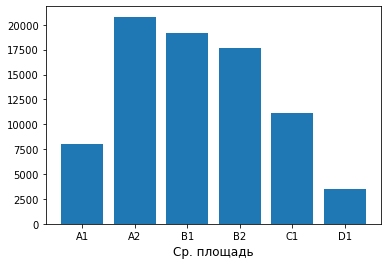

In [22]:
y_square = [np.mean(sqr_a1),np.mean(sqr_a2),np.mean(sqr_b1),np.mean(sqr_b2),np.mean(sqr_c1),np.mean(sqr_d1)]

plt.bar(x_names, y_square)
 
# Custom Axis title
plt.xlabel('Ср. площадь', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

Кластеризация

In [23]:
df = pd.DataFrame([], columns=["Площадь", "Фрактал","ЧП", "БП", "Отношение"], index = x_names)
df["Площадь"] = y_square
df['Фрактал'] = y_frac
df['Отношение'] = y_relate
df['ЧП'] = y_black
df['БП'] = y_white
df

,Площадь,Фрактал,ЧП,БП,Отношение
A1,8015.000000,1.204521,7777.75,237.250000,64.709558
A2,20807.000000,1.301222,20171.00,636.000000,31.768656
B1,19194.666667,1.414710,18612.00,582.666667,47.706668
B2,17615.250000,1.289262,16906.50,708.750000,66.059295
C1,11136.250000,1.293175,10182.00,954.250000,43.921704
D1,3479.750000,1.134932,2530.25,949.500000,2.760758


In [44]:
def knn_comparison(data,cat,i,clf):
    x = data.values.astype('int')
    y = pd.Categorical(cat).codes
    clf.fit(x, y)
    # Plotting decision region
    plot_decision_regions(x, y, clf=clf, legend=2)
    # Adding axes annotations
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Score of '+i+':'+ str(clf.score(x,y)))
    plt.show()

In [81]:
data = pd.DataFrame([], columns=["Площадь", "Фрактал", "Отношение", "ЧП", "БП", "Тип"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        x, y = c.shape
        TotalNumberOfPixels = x * y
        white = TotalNumberOfPixels - cv2.countNonZero(c)
        data = data.append({'Площадь': x*y, 
                            "Фрактал": fractal_dimension(c), 
                            "Отношение": cv2.countNonZero(c)/white, 
                            "ЧП": cv2.countNonZero(c), 
                            "БП": white,
                            "Тип": key}, ignore_index=True)

In [82]:
lr = LogisticRegression(random_state=1,
                      solver='newton-cg',
                      multi_class='multinomial')
rf = RandomForestClassifier(random_state=1, n_estimators=100)
gaus = GaussianNB()
neig = KNeighborsClassifier(n_neighbors=6)
algs = {
    "LogisticRegression":lr,
    "RandomForest":rf,
    "Gausian": gaus,
    "KNeighbors":neig
}

In [83]:
from sklearn.neighbors import KNeighborsClassifier
for i, clf in algs.items():
    clf.fit(data.drop(["Тип"],axis=1), data["Тип"])
    print("score of "+i+" is "+str(clf.score(data.drop(["Тип"],axis=1), data["Тип"])))

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


score of LogisticRegression is 0.7727272727272727
score of RandomForest is 1.0
score of Gausian is 0.7727272727272727
score of KNeighbors is 0.6363636363636364


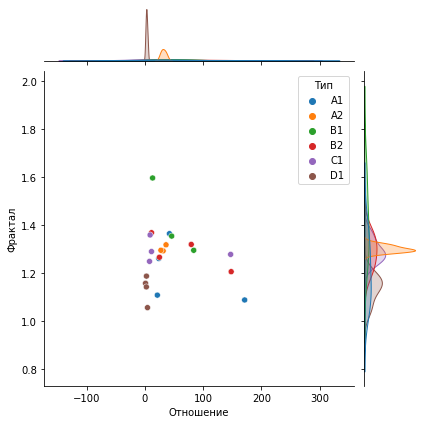

In [27]:
sns.jointplot(data=data, x="Отношение", y="Фрактал", hue="Тип")

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


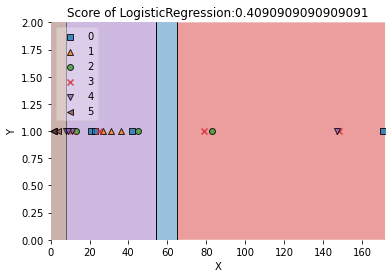

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


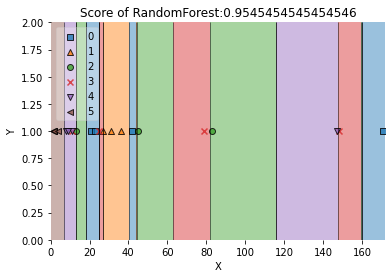

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


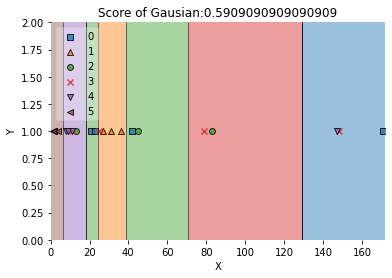

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


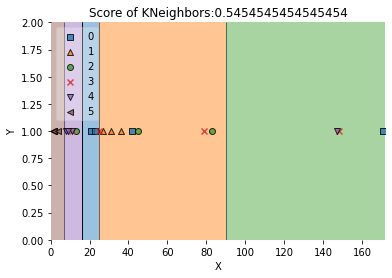

In [55]:
for i, clf in algs.items():
    knn_comparison(data[["Отношение","Фрактал"]], data["Тип"],i, clf)

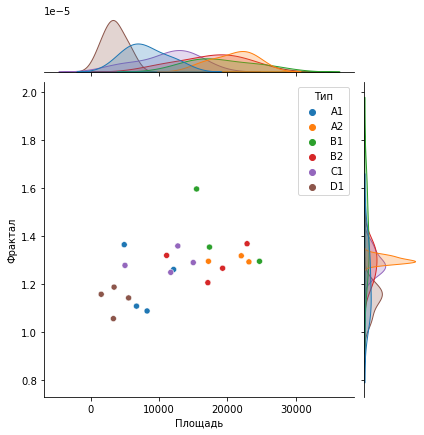

In [53]:
sns.jointplot(data=data, x="Площадь", y="Фрактал", hue="Тип")

/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


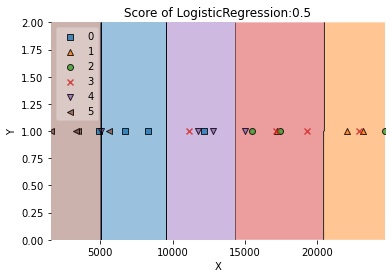

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


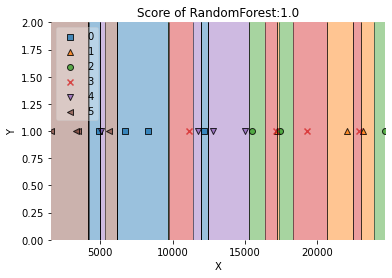

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


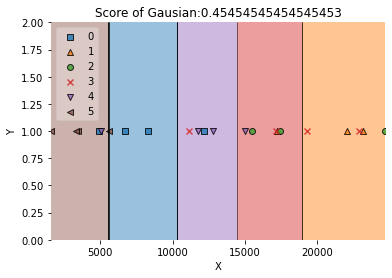

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


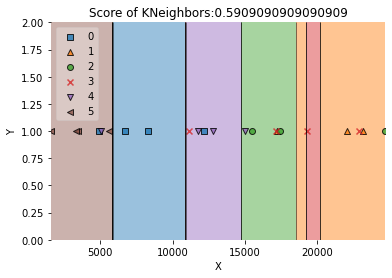

In [54]:
for i, clf in algs.items():
    knn_comparison(data[["Площадь","Фрактал"]], data["Тип"],i, clf)

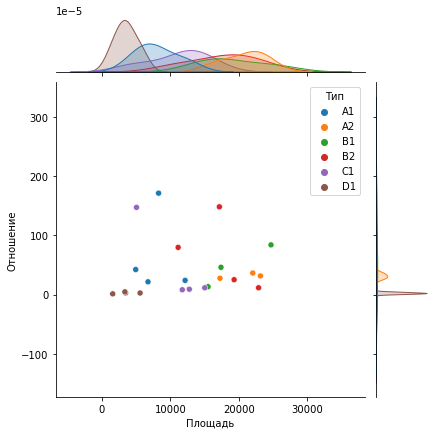

In [29]:
sns.jointplot(data=data, x="Площадь", y="Отношение", hue="Тип")

/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


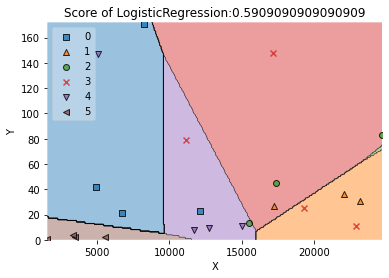

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


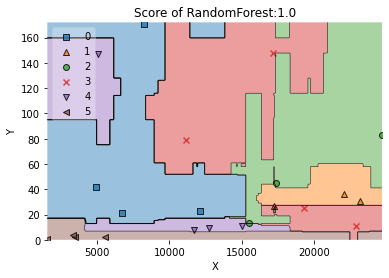

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


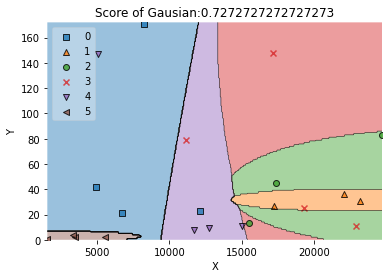

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


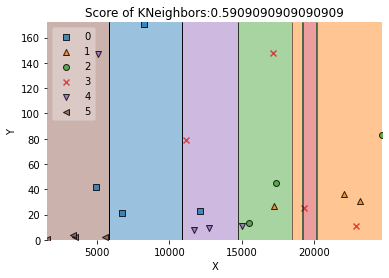

In [49]:
for i, clf in algs.items():
    knn_comparison(data[["Площадь","Отношение"]], data["Тип"],i, clf)

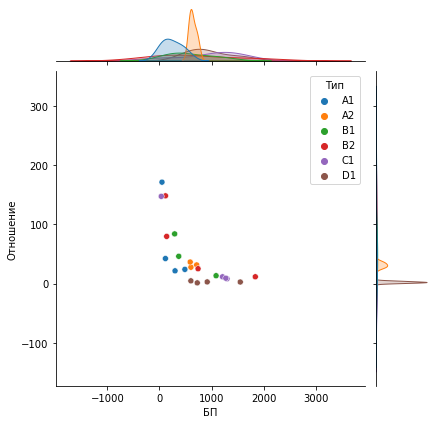

In [30]:
sns.jointplot(data=data, x="БП", y="Отношение", hue="Тип")

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


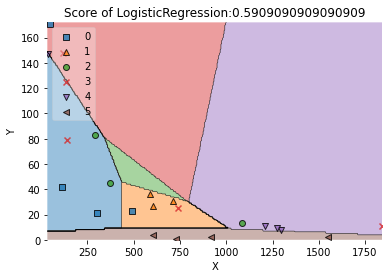

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


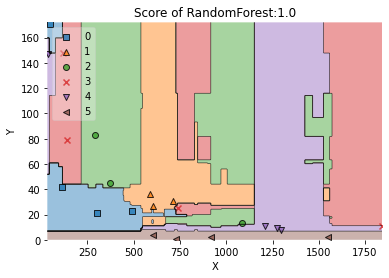

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


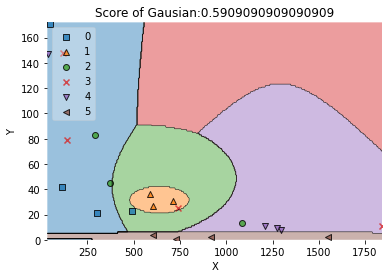

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


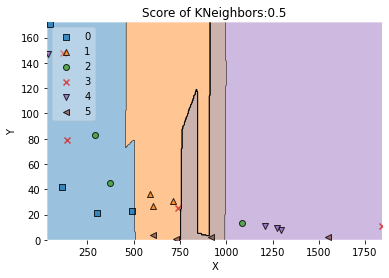

In [48]:
for i, clf in algs.items():
    knn_comparison(data[["БП", "Отношение"]], data["Тип"],i, clf)

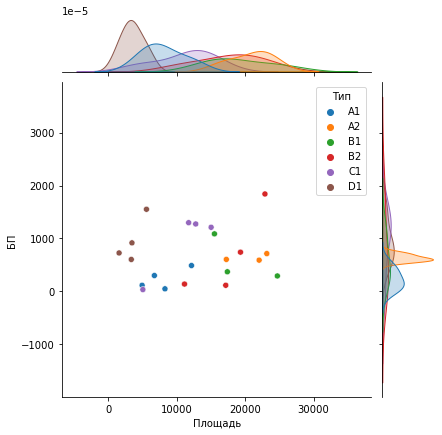

In [31]:
sns.jointplot(data=data, x="Площадь", y="БП", hue="Тип")

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


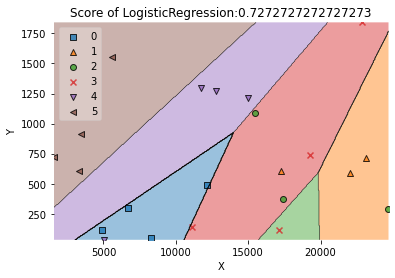

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


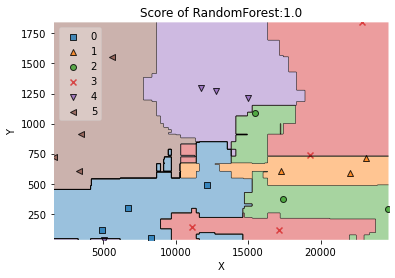

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


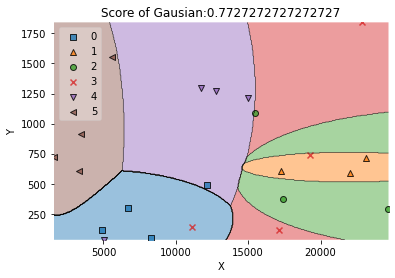

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


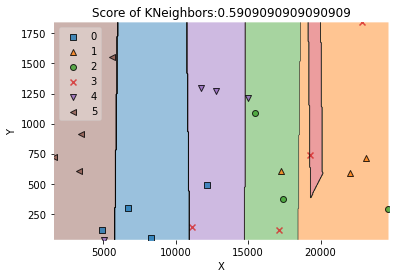

In [47]:
for i, clf in algs.items():
    knn_comparison(data[["Площадь","БП"]], data["Тип"],i, clf)

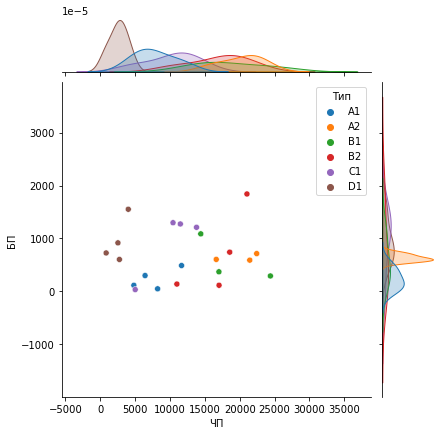

In [35]:
sns.jointplot(data=data, x="ЧП", y="БП", hue="Тип")

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


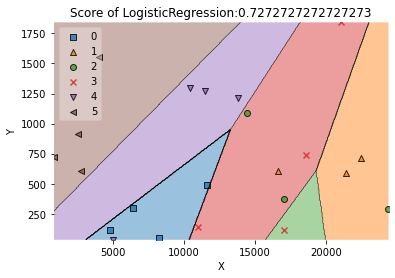

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


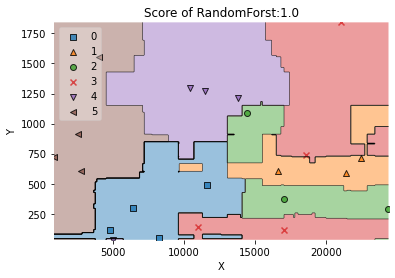

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


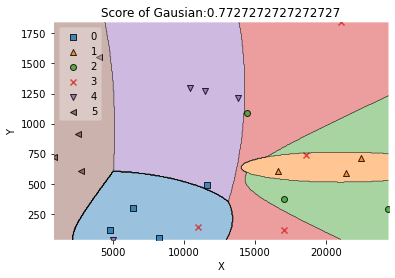

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


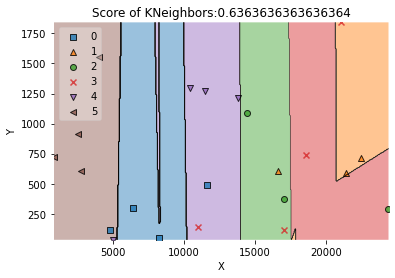

In [45]:
for i, clf in algs.items():
    knn_comparison(data[["ЧП","БП"]], data["Тип"],i, clf)